<a href="https://colab.research.google.com/github/BDonadelli/Codigos-em-financas/blob/main/IFR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ESTRATÉGIA
1.   IFR para 2 períodos < 5 compra na abertura seguinte
2.   Preço fechamento > ma5 vende na abertura seguinte



In [25]:
# @ Data é ano/mes/dia.

inicio  = '2020-01-02'  #@param {type:"date"}
termino = '2023-01-30'  #@param {type:"date"}
from datetime import datetime

usar_periodo = True #@param {type:"boolean"}
periodo = '2y' #@param ['1d','5d','1mo','3mo','6mo','1y','2y','3y','5y','10y','ytd','max']

In [26]:
# @ markdown Instala bibliotecas

import pandas as pd
import numpy as np

# import pyfolio as pf
import quantstats as qstats
import pandas_ta as pta

# !pip install -q  yfinance
import yfinance as yf

import cufflinks as cf
cf.go_offline()


import plotly.io as pio
pio.renderers.default = 'png'  ## comentar se quiser grafico interativo

In [27]:
arq = 'data/Cart_Ibov.csv'
# arq = 'data/Cart_IBr100.csv'
try:
    IBOV = pd.read_csv(arq, encoding='utf-8', sep=',' , index_col=False ,engine='python')
except:
    url = f'https://raw.githubusercontent.com/BDonadelli/Codigos-em-financas/main/{arq}'
    IBOV = pd.read_csv(url, encoding='utf-8', sep=',' ,index_col=False ,engine='python')



In [28]:
IBOV

,Código,Ação,Tipo,Qtde. Teórica,Part. (%)
0,VALE3,VALE,ON NM,4270903023,10.897
1,PETR4,PETROBRAS,PN N2,4431132660,7.490
2,ITUB4,ITAUUNIBANCO,PN EJ N1,4455161368,7.410
3,PETR3,PETROBRAS,ON N2,2448348744,4.534
4,BBAS3,BRASIL,ON NM,2842613858,3.681
...,...,...,...,...,...
81,AZUL4,AZUL,PN ATZ N2,328421113,0.065
82,EZTC3,EZTEC,ON NM,97334950,0.060
83,ALPA4,ALPARGATAS,PN N1,166460180,0.056
84,PCAR3,P.ACUCAR-CBD,ON NM,379327171,0.052


In [29]:
codigos = np.array(sorted(IBOV.Código.to_list()),dtype=str)
tickers = [tk+'.SA' for tk in codigos]
tickers[50]

'LWSA3.SA'

In [30]:
# @ markdown ## download dados do yahoo finance
## a ultima lina da tabela tem a data mais recente
df=pd.DataFrame()
if usar_periodo : 
  df = yf.download(tickers, period = periodo   , auto_adjust=True, progress = False )[['Open','Close']]
else: 
  df = yf.download(tickers, start = inicio , end = termino , auto_adjust=True, progress = False )[['Open','Close']]

d = dict(zip(df.columns.levels[1],df.columns.levels[1].str.rstrip('.SA') ))
df = df.rename(columns=d, level=1)

df.columns = [" ".join(col).strip() for col in df.columns.values]
df.head(1) #mostra a primeiro linha da tabela dos preços


2 Failed downloads:
['ALOS3.SA']: YFInvalidPeriodError("%ticker%: Period '2y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', 'max']")
['BRAV3.SA']: YFChartError('%ticker%: No data found, symbol may be delisted')


,Open ABEV3,Open ALOS3,Open ALPA4,Open ASAI3,Open AURE3,Open AZUL4,Open AZZA3,Open B3SA3,Open BBAS3,Open BBDC3,...,Close TRPL4,Close UGPA3,Close USIM5,Close VALE3,Close VAMO3,Close VBBR3,Close VIVA3,Close VIVT3,Close WEGE3,Close YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-06,13.938619,NaN,20.700001,19.284256,11.97773,16.27,88.494092,11.72283,16.831095,13.797499,...,20.315229,12.815587,7.486836,55.111126,13.352239,16.286184,24.980991,37.492149,29.27582,11.644688


In [31]:
# @ markdown  função qu, output: str = Nonee calcula o ifr a partir de uma serie de preços

def rsi(price, window=2, output: str = None):   
  '''
    calcula o ifr 
    "price" é uma série de preços
    "window" é o periodo da janela móvel de obeservação, por default vale 2      
    "output" é string com nome de arquivo para exportar contas em csv
    Referencia: https://seekingalpha.com/article/4518407-rsi-indicator-meaning-and-calculation 
  '''
    
  data = pd.DataFrame(price).copy()
    
  data["Variation"] = data.diff()

  data["Gain"] = np.where(data["Variation"] > 0, data["Variation"], 0)
  data["Loss"] = np.where(data["Variation"] < 0, data["Variation"], 0)

  data['avg_gain'] = data["Gain"].rolling(window,min_periods=window).mean()
  data['avg_loss'] = data["Loss"].abs().rolling(window,min_periods=window).mean()

  # avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
  # avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()
  # rs = avg_gain / avg_loss

  for i in range(window, len(data['avg_gain'])):
     data['avg_gain'].iloc[i] = (data['avg_gain'].iloc[i - 1] * (window - 1) + data["Gain"].iloc[i]) / window
     data['avg_loss'].iloc[i] = (data['avg_loss'].iloc[i - 1] * (window - 1) + data["Loss"].abs().iloc[i]) / window
  data['rsi'] = 100 - (100 / (1 + ( data['avg_gain'] / data['avg_loss'] ))).round(2)

  if output is not None:
        data.to_csv(output)

  return data['rsi']

**lista os ativos do índice com ifr2 < 5**


In [32]:
limiar_ifr=5.5

In [33]:
IFR = pd.DataFrame({f"{i}": rsi( df['Close '+i] , 2)  for i in codigos})

print('o ultimo preço é do dia',IFR.index[-1].day,'/',IFR.index[-1].month,'/',IFR.index[-1].year)
print('Os ativos com IFR<5 são:')
## seleciona os ativos dentre 'codigos' com ifr2 < 5 
lista_ifr=[]
for x in codigos :
  if IFR[x].iloc[-1]< limiar_ifr :  
    print(x)
    lista_ifr.append(x)

if len(lista_ifr)==0: print(F'*************** Não tem papel com IFR<{limiar_ifr} ***************')

o ultimo preço é do dia 6 / 9 / 2024
Os ativos com IFR<5 são:
PETR3
PETR4
PRIO3
RAIZ4
RECV3
SMTO3


**histórico da estratégia**

In [34]:
# @ markdown Simula as operações
def trades (x):
  '''
  'trades' cria duas listas 'entrada' e 'saida' 
  essas listas têm 3 componentes: 
    a linha na tabela de dados do sinal de entrada/saida;
    a data seguinte do sinal (entrada/saida), que é o dia de negociação, e 
    o preço (open) de entrada/saida naquele dia, preço da negociação
  '''
  open  = 'Open '+x
  close = 'Close '+x

  bt = df[[open , close]].copy() 
  #media movel simples de 5 periodos 
  bt['mm5'] = df[close].rolling(5).mean()  
  bt['ifr'] = IFR[x]
  bt=bt.dropna()
  
  ## marca todos os pontos com ifr2 < 5
  bt['sinal_entra'] = np.where(bt['ifr'] < 5 , 1 , 0)
  #marca todos pontos com close > mm5
  bt['sinal_sai'] = np.where(bt[close] > bt['mm5'] , -1 , 0)

  '''
  cria listas com os pontos de entrada e saída das operações
  1) percorre a tabela bt em ordem cronológica até achar sinal entrada
     quando acha, armazenas as informações: 
       linha da tabela, data do sinal e preço de abertura do dia seguinte
  2) em seguida, continua, a partir do proximo dia, até achar sinal saida
     quando acha, armazenas as informações: 
       linha da tabela, data do sinal e preço de fechamento do dia seguinte
  3) repete os passos 1 e 2 
  '''  
  entrada = []
  saida = []
  i=0
  while i < len(bt):
    while bt['sinal_entra'].iloc[i] == 0 : i+=1 # pega um sinal de entrada
    if i+1 < len(bt) :                          # se teve pregão dia seguinte,entra
        i+=1                                    # vai p/ dia seguinte
        entrada.append( ( i-1,                                      # sinal no dia anterior
                         bt.index[i].date().strftime("%d/%m/%Y") ,  # dia entrada
                         np.round(bt[open].iloc[i],2)))             # preço entrada
       #avança até o primeiro sinal de saída, que pode ser no proprio dia
        while (i < len(bt) and bt['sinal_sai'].iloc[i]==0) : i=i+1    
       #se teve pregão dia seguinte,sai  (senão vai dormir comprado, vamos desconsiderar)
        if i+1 < len(bt) :  
            i+=1                                                        # vai p/ dia seguinte
            saida.append( (i-1,                                         # sinal no dia anterior
                           bt.index[i].date().strftime("%d/%m/%Y")  ,   # dia saida
                           np.round(bt[open].iloc[i],2)) )              # preço saida
            # senão, a ultima operação ainda não deu saida , remove ultima entrada
        else : entrada.pop()                    
    i=i+1
  return entrada,saida

In [35]:
# @ markdown Mostra os resultados

resumo = pd.DataFrame(index=lista_ifr,columns=[ \
    'IFR2',                    # ifr do papel
    'Operações' ,              # no. de operações no periodo
    'Positivas' ,     # no. de operações com retorno >0
    'Tx acerto' ,              # Retornos positivos / Retornos 
    'Acumulado',               # Retorno acumulado pela estratégia 
    'Ret. médio pos' ,          # média aritmetica dos retornos > 0
    'Ret. médio neg' ,          # média aritmetica dos retornos < 0
    'Exp matematica',
    'Duração média(dias)' ])   # no. medio de dias que fica posicionado

# usando as informações da função 'trades', simula as operações
# calcula o tempo de cada operação e a variação do preço do ativo

out =  [ [[],[]] for j in range(len(lista_ifr))] 
retornos = [ [[],[]] for j in range(len(lista_ifr))] 
z=0
for x in lista_ifr:
  dura = []  ## duração da operação, em dias uteis
  e    = []  ## pontos de entrada 
  s    = []  ## pontos de saida
  posret = 0 ## conta retornos positivos

  e,s = trades(x)
  # mensagens para ajudar na validação
  out1 =  ['' for j in range(len(e))] # entrada/saida
  out2 =  ['' for j in range(len(e))] # duração
  out3 =  ['' for j in range(len(e))] # retorno
  
  for j in range(len(e)) :
      out1[j] =  "entrada em " + str(e[j][1]) + " e saida em " + str(s[j][1]) 
      
      dias = s[j][0] - e[j][0]
      out2[j] = " durou "+str(dias)+" dias e "
      dura.append(dias)

      retorno = s[j][2]/e[j][2] - 1
      out3[j] = "variou "+str(round(retorno*100,3))+"%" 
      retornos[z][1].append(retorno)
      if retorno > 0 : posret +=1
  
  if len(retornos[z][1])!=0 : wins = np.round(posret/(len(retornos[z][1])),3) 
  else : wins = 0
  retpos = np.round(np.mean([x for x in retornos[z][1] if x>0]),2)
  retneg = abs(np.round(np.mean([x for x in retornos[z][1] if x<=0]),2))
  expectativa = (wins * retpos) - ((1 - wins) * retneg)

  resumo.loc[x] = [ IFR[x].iloc[-1].round(2), 
                   len(e) , 
                   posret , 
                   wins,
                   np.round((np.array(retornos[z][1])+1).cumprod()[-1] - 1,2) , 
                   retpos, 
                   retneg,
                   expectativa*100, 
                   np.round(np.mean(dura),1) 
                   ]
  
  retornos[z][0] = x
  out[z][0] = x
  for j in range(len(e)) : 
        out[z][1].append(out1[j] + out2[j]+out3[j])        
  z=z+1

resumo = resumo.sort_values(by=['Exp matematica'], ascending=False)
display(resumo.sort_values(by=['Exp matematica'], ascending=False))

,IFR2,Operações,Positivas,Tx acerto,Acumulado,Ret. médio pos,Ret. médio neg,Exp matematica,Duração média(dias)
RECV3,3.34,18,15,0.833,0.66,0.04,0.04,2.664,3.1
PRIO3,0.36,14,10,0.714,0.19,0.04,0.05,1.426,4.1
RAIZ4,4.4,18,13,0.722,0.17,0.03,0.04,1.054,4.3
PETR4,1.38,13,10,0.769,0.08,0.03,0.07,0.69,3.5
SMTO3,0.54,15,9,0.6,0.07,0.03,0.03,0.6,4.6
PETR3,1.88,15,9,0.6,0.02,0.03,0.04,0.2,4.0


analise 1º ativo da lista

In [50]:
ativo = resumo.index[0]
print('bt de ',ativo)

bt de  RECV3


In [51]:
entrada,saida = trades(ativo)
entra = [datetime.strptime(x[1] , "%d/%m/%Y") for x in entrada]
sai   = [datetime.strptime(x[1] , "%d/%m/%Y") for x in saida]

In [52]:
posicao = pd.DataFrame(columns=['pos'], index=df.index)
posicao.loc[entra] = 1
posicao.loc[sai] = 0
posicao.ffill(inplace=True)
posicao.fillna(0,inplace=True)
# posicao.iplot()

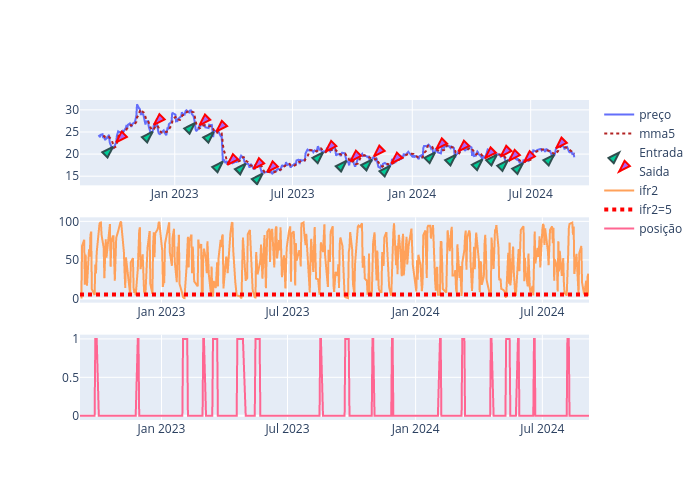

In [53]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df['Close '+ativo].rolling(5).mean() 


fig = make_subplots(rows=3, cols=1) #go.Figure()
fig.add_trace(go.Scatter(x = df.index , y = df['Close '+ativo].values , name="preço"),1,1)
fig.add_trace(go.Scatter(x = df.index , y =  df['Close '+ativo].rolling(5).mean(), mode='lines', 
                         line=dict(color='firebrick', width=2, dash='dot'), name="mma5"),1,1)

fig.add_trace(go.Scatter(x = df.loc[entra].index, y = df.loc[entra]['Close '+ativo] , mode='markers' ,name='Entrada',
                             marker=dict(size=12, symbol="arrow", angle=45, line=dict(width=2, color="DarkSlateGrey"))
                         ),1,1)
fig.update_traces(
    marker=dict(size=12, symbol="arrow", angle=45, line=dict(width=2, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.add_trace(go.Scatter(x = df.loc[sai].index, y = df.loc[sai]['Close '+ativo] , mode='markers' ,name='Saida',
                         marker=dict(size=12, symbol="arrow", angle=-135, line=dict(width=2, color="red"))
                         ),1,1)
fig.add_trace(go.Scatter(x = df.index , y = IFR[ativo].values , name="ifr2"),2,1)
fig.add_trace(go.Scatter(x = df.index , y = [5]*len(df.index) , name="ifr2=5", mode='lines', 
              line=dict(color='red', width=4, dash='dot')),2,1)

fig.add_trace(go.Scatter(x =posicao.index , y = posicao['pos'] , mode='lines', name="posição"),3,1)


fig.show()

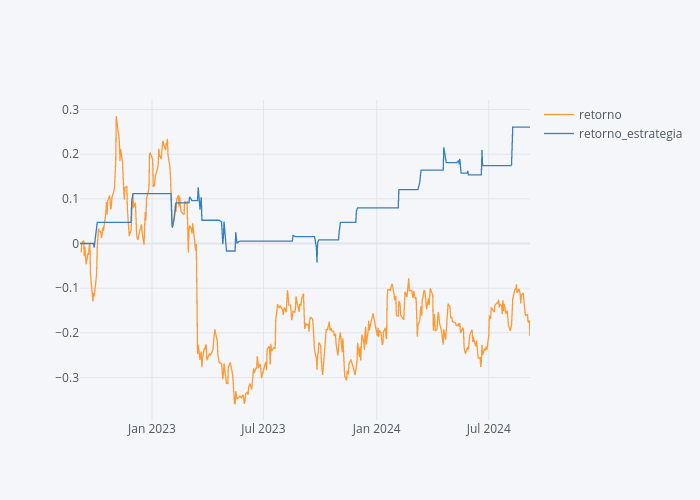

In [64]:
ohlc = yf.download(tickers= ativo+'.SA', period = periodo , auto_adjust=True, progress = False )
ohlc['retorno'] = ohlc['Close'].pct_change()
## calculating stretegy returns
ohlc['retorno_estrategia'] = ohlc['retorno'] * (posicao['pos'].shift(1))
# ohlc.fillna(0,inplace=True)
ohlc['retorno_estrategia'].fillna(0,inplace=True)
ohlc[ohlc['retorno_estrategia']!= 0.0]
((ohlc[['retorno', 'retorno_estrategia']]+1).cumprod()-1).iplot();

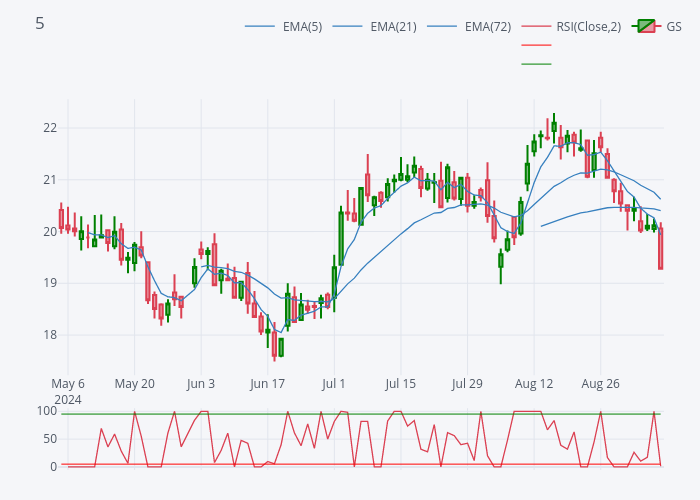

In [55]:
ohlc = yf.download(tickers= ativo+'.SA', period = periodo , auto_adjust=True, progress = False )

qf=cf.QuantFig(ohlc[-90:] , title= x ,legend='top',name='GS',up_color='green', down_color='red' )
#qf.add_bollinger_bands(periods=20, boll_std=2, colors=['cyan','grey'], fill=True)
qf.add_ema(periods=5)
qf.add_ema(periods=21)
qf.add_ema(periods=72)
qf.add_rsi(periods=2,color='red',rsi_upper=95,rsi_lower=5,showbands=True)

fig = qf.figure()
fig.update_xaxes(
    rangebreaks=[dict(bounds=["sat", "mon"])])
fig.show()

**informações dos trades**

In [56]:
for x in range(len(lista_ifr)):
  print("\n******",retornos[x][0],"(retornos) ********")
  print('resumo dos retornos das operações:')
  print(pd.Series(retornos[x][1]).describe()  );


****** PETR3 (retornos) ********
resumo dos retornos das operações:
count    15.000000
mean      0.002378
std       0.040536
min      -0.088041
25%      -0.010489
50%       0.007683
75%       0.029617
max       0.056591
dtype: float64

****** PETR4 (retornos) ********
resumo dos retornos das operações:
count    13.000000
mean      0.007350
std       0.048787
min      -0.108025
25%       0.001562
50%       0.021995
75%       0.043335
max       0.054952
dtype: float64

****** PRIO3 (retornos) ********
resumo dos retornos das operações:
count    14.000000
mean      0.014006
std       0.050884
min      -0.081871
25%       0.000173
50%       0.021521
75%       0.034127
max       0.098630
dtype: float64

****** RAIZ4 (retornos) ********
resumo dos retornos das operações:
count    18.000000
mean      0.009513
std       0.040356
min      -0.089947
25%      -0.003827
50%       0.019263
75%       0.035939
max       0.055728
dtype: float64

****** RECV3 (retornos) ********
resumo dos retornos da

In [57]:
out

[['PETR3',
  ['entrada em 14/09/2022 e saida em 20/09/2022 durou 4 dias e variou 2.521%',
   'entrada em 01/11/2022 e saida em 14/11/2022 durou 8 dias e variou -7.358%',
   'entrada em 12/12/2022 e saida em 20/12/2022 durou 6 dias e variou -8.804%',
   'entrada em 03/01/2023 e saida em 06/01/2023 durou 3 dias e variou 2.973%',
   'entrada em 23/02/2023 e saida em 24/02/2023 durou 1 dias e variou 3.691%',
   'entrada em 15/03/2023 e saida em 22/03/2023 durou 5 dias e variou -1.071%',
   'entrada em 12/07/2023 e saida em 14/07/2023 durou 2 dias e variou 0.515%',
   'entrada em 06/10/2023 e saida em 09/10/2023 durou 1 dias e variou 5.659%',
   'entrada em 01/11/2023 e saida em 06/11/2023 durou 2 dias e variou 2.431%',
   'entrada em 09/11/2023 e saida em 14/11/2023 durou 3 dias e variou 3.374%',
   'entrada em 07/12/2023 e saida em 11/12/2023 durou 2 dias e variou 2.951%',
   'entrada em 29/02/2024 e saida em 07/03/2024 durou 5 dias e variou -1.026%',
   'entrada em 11/03/2024 e saida em 

In [58]:
import talib
talib.RSI(ohlc["Close"] , 2)

Date
2022-09-06          NaN
2022-09-08          NaN
2022-09-09    51.694842
2022-09-12    61.486380
2022-09-13    16.727973
                ...    
2024-09-02    22.998783
2024-09-03     5.428445
2024-09-04    28.344077
2024-09-05    32.005435
2024-09-06     3.339466
Length: 501, dtype: float64

In [59]:
rsi(ohlc["Close"])

Date
2022-09-06      NaN
2022-09-08     0.00
2022-09-09    68.16
2022-09-12    76.15
2022-09-13    17.65
              ...  
2024-09-02    23.00
2024-09-03     5.43
2024-09-04    28.34
2024-09-05    32.01
2024-09-06     3.34
Name: rsi, Length: 501, dtype: float64

In [60]:
import quantstats as qs

help(qs.reports.full)

Help on function full in module quantstats.reports:

full(returns, benchmark=None, rf=0.0, grayscale=False, figsize=(8, 5), display=True, compounded=True, periods_per_year=252, match_dates=True, **kwargs)



In [61]:
ohlc

,Open,High,Low,Close,Volume
Date,,,,,
2022-09-06,24.980471,25.041082,24.019350,24.322407,1834000
2022-09-08,24.504236,24.625460,23.274695,23.828856,1939300
2022-09-09,24.331065,24.798636,24.019350,24.357040,1889700
2022-09-12,24.703390,25.214256,24.183865,24.486921,1883700
2022-09-13,24.088620,24.383017,23.317992,23.629707,1769500
...,...,...,...,...,...
2024-09-02,20.400000,20.670000,20.200001,20.450001,1325300
2024-09-03,20.200001,20.490000,19.969999,20.020000,2174500
2024-09-04,20.059999,20.340000,20.010000,20.110001,2121600


In [62]:
import warnings
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

qs.reports.full(ohlc['retorno_estrategia'] )

KeyError: 'retorno_estrategia'